In [17]:
import gurobipy as grb
import numpy as np

opt_model = grb.Model(name="MIP Model")
opt_model.setParam("NonConvex", 2)
opt_model.setParam("TimeLimit", 100)

Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter TimeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [1]:
# get data
from dataset import MovieLensDataset
d = MovieLensDataset('/home/nick/datasets/gurobi_data/', mode='sparse')
# d = MovieLensDataset('data/', mode='sparse')

Loading MovieLens dataset from /home/nick/datasets/gurobi_data/ with mode sparse..
Column names are userId, movieId, rating, timestamp
Processed 1140 lines. 10 users x 867 movies.
Dataset contains 1139 ratings (13.137254901960786% matrix density)


In [2]:
rows, cols = d.X.nonzero()
ratings = d.X.data

In [20]:
u = opt_model.addVars(d.n_users, lb=-20.0, ub=20.0, vtype=grb.GRB.CONTINUOUS, name="users")
v = opt_model.addVars(d.n_movies,lb=-20.0, ub=20.0, vtype=grb.GRB.CONTINUOUS, name="movies")
# theta = opt_model.addVars(d.n_users, d.n_movies, vtype=grb.GRB.INTEGER)
# x_vars  ={(i,j):opt_model.addVar(vtype=grb.GRB.INTEGER,
#                         name="x_{0}_{1}".format(i,j)) for i in rows for j in cols}

In [21]:
# objective = grb.quicksum((u[i]*v[j] - d.X[i,j])**2
#                          for i, j in zip(rows, cols))
# objective = sum((u[rows[i]]*v[cols[i]] - d.X[rows[i], cols[i]]) for i in range(len(ratings)))
objective = 0
for i, j in zip(rows, cols):
    z = opt_model.addVar(name=f'z_{i}_{j}')
    opt_model.addConstr(u[i]*v[j] == z)
    objective += (z - d.X[i, j]) * (z - d.X[i, j])


In [22]:
opt_model.setObjective(objective, grb.GRB.MINIMIZE)
opt_model.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 0 rows, 2016 columns and 0 nonzeros
Model fingerprint: 0xf6b71ef4
Model has 1139 quadratic objective terms
Model has 1139 quadratic constraints
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e+01, 2e+01]
  RHS range        [0e+00, 0e+00]

Continuous model is non-convex -- solving as a MIP.

Presolve time: 0.00s
Presolved: 4556 rows, 2016 columns, 13668 nonzeros
Presolved model has 1139 quadratic objective terms
Presolved model has 1139 bilinear constraint(s)
Variable types: 2016 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 1701 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl

In [23]:
u_arr = np.array([u[i].X for i in range(d.n_users)])
v_arr = np.array([v[i].X for i in range(d.n_movies)])
v_arr

array([-0.44687629, -0.46980928, -0.41985584, -0.41530558, -0.4244836 ,
       -0.3       , -0.5       , -0.42671747, -0.47669432, -0.5       ,
       -0.42700774, -0.47486636, -0.35005477, -0.4257459 , -0.33028434,
       -0.5485825 , -0.31501264, -0.357699  , -0.49214009, -0.43068868,
       -0.4594099 , -0.42491291, -0.4060017 , -0.30111534, -0.28812664,
       -0.48069   , -0.47868411, -0.34767677, -0.45877194, -0.37141814,
       -0.37141814, -0.44942539, -0.50584471, -0.34731257, -0.4783556 ,
       -0.46831755, -0.44340898, -0.36534367, -0.50185889, -0.30111534,
       -0.4       , -0.41526294, -0.44208543, -0.40148712, -0.54408255,
       -0.5       , -0.5       , -0.40148712, -0.50185889, -0.30111534,
       -0.5       , -0.50185889, -0.49430412, -0.50185889, -0.30111534,
       -0.50185889, -0.50185889, -0.37141814, -0.52642953, -0.33716228,
       -0.44346953, -0.54408255, -0.50185889, -0.4       , -0.50185889,
       -0.5       , -0.40148712, -0.54408255, -0.51253246, -0.54

In [24]:
v_arr.shape
u_arr.shape

(10,)

In [25]:
u_arr = u_arr.reshape(-1, 1)
v_arr = v_arr.reshape(-1, 1)

# let's now evaluate the MEAN squared error (above we're just dealing with sum of squared errors)
from main import evaluate
mse = evaluate(u_arr, v_arr, d.X, 'sparse')
mse

(10, 1) (867, 1) (10, 867) sparse
Test set MSE: 1.0817177984594597


1.0817177984594597

In [17]:
# let's see whether fun eval matches
from als import ALSSparse
als = ALSSparse(u=u_arr, v=v_arr, dataset=d.X)
als.function_eval()

1221.513500325544

In [13]:
# check saved vectors
u = np.load('./data/gurobi_U.npy')
u = u.astype(np.float64)
v = np.load('./data/gurobi_V.npy')
v = v.astype(np.float64)
from als import ALSSparse, ALS
als = ALS(u=u, v=v, dataset=d.X.A)
als.function_eval()

12274293.05495823

In [16]:
from main import evaluate
mse = evaluate(u, v, d.X, 'full')
mse

(10,) (867,) (10, 867) full
Test set MSE: 10776.37669443216


10776.37669443216

In [3]:
from scipy import optimize
import numpy as np

def f(theta, nusers):
    u = theta[:nusers].reshape(-1, 1)
    v = theta[nusers:].reshape(-1, 1)
    return np.sum( (M*(u@v.T)-X)**2 )
X = d.X.A
M = X.astype(np.bool)
theta0 = np.abs(np.random.randn(d.n_users+d.n_movies))
theta0 /= np.linalg.norm(theta0)
theta = theta0

In [5]:
import time
sc_times = []
sc_solutions = []
for i in range(5):
    start =  time.time()
    sol = optimize.minimize(f, theta, args=(d.n_users,))
    elapsed = time.time()-start
    print(elapsed)
    sc_times.append(elapsed)
    sc_solutions.append(sol)

114.31849837303162
114.74017190933228
113.59453582763672
113.80168032646179
113.6618287563324


In [12]:
for sol in sc_solutions:
    print(f'MSE: {f(sol.x, d.n_users)/np.count_nonzero(X)}--Norm:{np.linalg.norm(sol.x)}-- n_iter: {sol.nit}')

MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851


In [14]:
np.array(sc_times).mean()

114.02334303855896

In [19]:
from als import ALSSparse
from main import average_stats, init_vector

def run_experiment(data: MovieLensDataset,
                   sparse=True,
                   grad_sensibility=1e-8,
                   num_experiments=1,
                   warmup=0,
                   workers=8):
#     date = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    trainX = data.X

    # print(trainX.shape, testX.shape)
    # optional warmup
    for _ in range(warmup):
        u = init_vector(data.n_users, normalize=True)
        v = init_vector(data.n_movies, normalize=True)
        args = [u, v, trainX]
        als = ALSSparse(*args) if sparse else ALS(*args)
        u, v = als.fit(eps_g=grad_sensibility)

    stats = {}
    start = time.time()
    for i in range(num_experiments):
        u = init_vector(data.n_users, normalize=True)
        v = init_vector(data.n_movies, normalize=True)
        args = [u, v, trainX]
        als = ALSSparse(*args) if sparse else ALS(*args)
        # run Alternating Least Squares algorithm
        u, v = als.fit(eps_g=grad_sensibility)
        # average results
        stats = average_stats(stats, als.stats, i + 1)
    end = time.time()
    # additional context info non depending from experiment results
    stats['number_of_ratings'] = trainX.getnnz(
    ) if sparse else np.count_nonzero(trainX)
    stats['dataset_path'] = data.path
    stats['grad_sensibility'] = grad_sensibility
    stats['theta_diff_sensibility'] = 1e-10
    stats['num_experiments'] = num_experiments
    stats['warmup_cycles'] = warmup
    stats['experiments_total_runtime'] = end - start
#     stats['date'] = date
    stats['train_mse'] = als.function_eval() / stats['number_of_ratings']
    print("Train Mean Squared error is:", stats['train_mse'])
#     print("Saving results..")
#     with open(f'data/als_{"sparse" if sparse else "full"}_{date}.json',
#               'w') as f:
#         json.dump(stats, f, indent=4)

    return stats, als
# als = ALS(u=theta[:d.n_users], v=theta[d.n_users:], dataset=X)
# us, vs = als.fit()
stats, als = run_experiment(d, num_experiments=5, warmup=1) 


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[1]		1414.743915881283		4.070705471473702		35308.324169765496

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[2]		1335.5743973112167		3.1597194611009		1113.2324279831166

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[3]		1293.5715420442891		2.4944886701123883		823.0659234362881

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[4]		1267.7710899881586		1.9755038759852241		644.8919070357028

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[5]		1251.4339752151802		1.5691338776897972		512.0119973725886

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[6]		1240.9400591128315		1.2510357406955925		409.04657103401104

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[7]		1234.1099519832194		1.0016810350460703		328.4705099852687

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[63]		1219.3290395717636		0.0014092431981531717		0.3183962234145621

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[64]		1219.3290220942267		0.0012866858482217015		0.28968926103487863

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[65]		1219.3290075498157		0.0011747980843103715		0.26361167075974995

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[66]		1219.3289954451445		0.0010726486447210691		0.23991723611407598

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[67]		1219.3289853700715		0.0009793880111453668		0.21838349709414195

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[68]		1219.3289769835992		0.0008942411476056199		0.19880936734460977

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[69]		1219.3289700021749		0.0008165009003309263		0.18101300212088242

Iteration	Function Eval (Lo


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[124]		1219.3289352458792		5.480883710146464e-06		0.0011443480870940428

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[125]		1219.328935245625		5.003943277516855e-06		0.001044448240581498

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[126]		1219.328935245413		4.568497638436607e-06		0.0009532780569216143

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[127]		1219.3289352452366		4.170937534048716e-06		0.0008700736312817397

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[128]		1219.3289352450893		3.8079675519927624e-06		0.0007941380471024823

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[129]		1219.328935244967		3.4765788359354567e-06		0.0007248354725203672

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[130]		1219.3289352448649		3.174024193828676e-06		0.0006615857927782634

Iterati


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[1]		1587.9040873735098		5.6150207448141956		36147.361565807594

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[2]		1363.8639764173981		3.6109671928862817		2287.9220985971197

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[3]		1287.096416809854		2.341879202421438		1140.0373329079162

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[4]		1258.0979427428988		1.6205068418080237		635.4774530776261

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[5]		1244.211831303864		1.1848794664752538		422.96628858966847

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[6]		1236.313716706127		0.8988084709524679		313.78748034012074

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[7]		1231.396600196608		0.7006541750212881		242.79703506141863

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[62]		1219.3291535022581		0.0020594158413352157		0.43291841041768947

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[63]		1219.3291170828822		0.0018796265228890625		0.3951375281858598

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[64]		1219.3290867450196		0.001715559435205691		0.36066487846123274

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[65]		1219.3290614720916		0.001565835575246295		0.32920881479894326

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[66]		1219.3290404177003		0.001429197549319226		0.30050374399352875

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[67]		1219.3290228770793		0.0013044987426150036		0.27430773967887107

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[68]		1219.329008263349		0.0011906934706886647		0.25040038463883213

Iteration	Function Eval (Loss)	


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[137]		1219.3289352446059		2.2092333378885423e-06		0.00046745236925058696

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[138]		1219.3289352445638		2.0168375498558345e-06		0.0004267583390491179

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[139]		1219.3289352445286		1.8411975498470356e-06		0.0003896066582135334

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[140]		1219.3289352444995		1.6808540085461722e-06		0.00035568899588507097

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[141]		1219.3289352444754		1.5344746964793472e-06		0.0003247238602123239

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[142]		1219.328935244455		1.4008434250273364e-06		0.0002964542616921897

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[143]		1219.328935244438		1.2788499274969012e-06		0.0002706455712349388


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[197]		1219.3289352443535		9.335713507573227e-09		1.9773305714647112e-06
--------------------------------------------------------------------------------
Estimated average iteration runtime: 0.010573964433621633s
Estimated average function evaluation times: 0.0003729907389219642

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[1]		1464.1311621395325		4.2631569559071165		36378.8164344041

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[2]		1359.2479584038067		3.3551322309026617		1451.8413000122675

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[3]		1302.6792385566912		2.632777463365033		1047.6181742420663

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[4]		1269.7353277391949		2.0517150612279003		784.3788924244445

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[5]		1250.1923974218294		1.5945447626000324		597


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[76]		1219.3289413529228		0.00034055691857672775		0.07353371790437552

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[77]		1219.328940335623		0.00031092062619926455		0.06712713544505812

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[78]		1219.3289394877238		0.00028386246235244297		0.061278647789078794

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[79]		1219.3289387810212		0.0002591582843138906		0.05593966094563956

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[80]		1219.3289381920051		0.00023660341616945252		0.05106580692162459

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[81]		1219.3289377010797		0.00021601096116189371		0.046616577209336034

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[82]		1219.3289372919116		0.000197210259896891		0.04255498789500481

Iteration	Function Ev


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[138]		1219.3289352444292		1.2012609854483914e-06		0.0002584831263184965

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[139]		1219.3289352444167		1.0966638161388787e-06		0.00023597176579285724

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[140]		1219.3289352444062		1.00117405136407e-06		0.00021542101880653671

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[141]		1219.3289352443974		9.139987175617214e-07		0.00019666011465842095

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[142]		1219.32893524439		8.344138835577606e-07		0.00017953315344352045

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[143]		1219.3289352443837		7.617586460771527e-07		0.00016389782646191573

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[144]		1219.328935244379		6.954296457553519e-07		0.00014962421645238353

I

[24]		1219.6587771878712		0.07569078167284357		21.1883760407759

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[25]		1219.6001351930681		0.06877912361353973		19.00259914083978

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[26]		1219.5521610968858		0.06253216510482196		17.06374185249237

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[27]		1219.5128544762965		0.05687906047273017		15.339947088384342

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[28]		1219.4806050696504		0.05175801983678936		13.804240920646572

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[29]		1219.4541128139904		0.04711481880437311		12.433634659135711

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[30]		1219.4323252829238		0.04290162339399697		11.208418714865925

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[31]		1219.4143884693483		0.039076050244688375		10.1


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[103]		1219.328935398611		5.469788387839045e-05		0.011609455543319496

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[104]		1219.3289353729103		4.993874862120873e-05		0.010595042320524987

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[105]		1219.3289353514917		4.5593608112451605e-05		0.009669392034702235

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[106]		1219.3289353336418		4.162645786358954e-05		0.008824721726902166

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[107]		1219.328935318766		3.800442383434938e-05		0.00805393295901731

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[108]		1219.3289353063687		3.469749030711793e-05		0.007350551310380624

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[109]		1219.3289352960371		3.1678251433566544e-05		0.006708671308400825

Iteration	Fun


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[166]		1219.328935244355		1.7632432416184443e-07		3.703477651595149e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[167]		1219.3289352443546		1.609724553027105e-07		3.3808674394988244e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[168]		1219.3289352443544		1.469571595791491e-07		3.0863632139003e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[169]		1219.3289352443542		1.3416207567086567e-07		2.8175157402275337e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[170]		1219.3289352443544		1.2248097717713901e-07		2.5720899069008747e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[171]		1219.328935244354		1.1181687746785354e-07		2.348045076487767e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[172]		1219.328935244354		1.0208123695518237e-07		2.143517808392004e-05

It


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[46]		1219.330493632955		0.005523102782494639		1.1899484750241136

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[47]		1219.3302325836892		0.005041198865678922		1.0836516376323453

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[48]		1219.3300153592772		0.004601497080616739		0.9870056072489408

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[49]		1219.329834579779		0.004200271077837348		0.8991090782081883

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[50]		1219.3296841133943		0.003834129716782179		0.8191492042307174

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[51]		1219.3295588640763		0.003499985604552164		0.746392138415165

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[52]		1219.3294545955996		0.0031950268773552376		0.6801747344277537

Iteration	Function Eval (Loss)		Current ||


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[111]		1219.3289352553852		1.483825280600509e-05		0.0030496583577876053

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[112]		1219.3289352535478		1.354665080425365e-05		0.002783772217903464

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[113]		1219.3289352520162		1.2367464981507615e-05		0.0025410781182077314

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[114]		1219.3289352507397		1.1290912322673256e-05		0.0023195518051308747

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[115]		1219.3289352496759		1.030806106229808e-05		0.0021173458915735386

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[116]		1219.328935248789		9.4107566015529e-06		0.0019327743325118012

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[117]		1219.3289352480504		8.591553910921108e-06		0.0017642983781816094

Iterati


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[169]		1219.3289352443537		7.5332663455474e-08		1.5420393663726306e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[170]		1219.3289352443537		6.877331140081728e-08		1.4077376476234018e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[171]		1219.3289352443537		6.278508528110954e-08		1.2851337478294268e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[172]		1219.3289352443537		5.731825235523366e-08		1.1732082060135209e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[173]		1219.3289352443535		5.232741863876793e-08		1.0710311392589391e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[174]		1219.3289352443535		4.7771141851277754e-08		9.777532275147027e-06

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[175]		1219.3289352443537		4.361158024757522e-08		8.925996486630135e-06

I


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[41]		1219.3394027506308		0.014489926903678611		2.983494885908985

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[42]		1219.3376392730488		0.013213526232551863		2.717035190825084

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[43]		1219.3361743131632		0.012050591491076413		2.474958892419843

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[44]		1219.334956997156		0.010990867210617882		2.2549351635452273

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[45]		1219.3339452032467		0.01002505277549926		2.0548727090873387

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[46]		1219.3331040363148		0.009144708888479786		1.872892398386586

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[47]		1219.3324045731206		0.008342173963467907		1.7073034611315212

Iteration	Function Eval (Loss)		Current ||grad

[116]		1219.3289352561906		1.5363043399297826e-05		0.00315024703160437

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[117]		1219.3289352542188		1.4024971240975623e-05		0.002876058025455706

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[118]		1219.3289352525753		1.2803449798259612e-05		0.0026257309474927966

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[119]		1219.3289352512058		1.1688326029373597e-05		0.0023971894180102303

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[120]		1219.3289352500644		1.067033146437489e-05		0.002188537729226907

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[121]		1219.328935249113		9.741005161319575e-06		0.0019980450909831316

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[122]		1219.3289352483202		8.892623297381731e-06		0.0018241313141284766

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[123]		


Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[176]		1219.3289352443537		6.490249263709003e-08		1.3333783737490246e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[177]		1219.3289352443535		5.925075301636301e-08		1.2172810862834178e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[178]		1219.3289352443535		5.409116867163601e-08		1.1112914669800095e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[179]		1219.3289352443535		4.9380891639599064e-08		1.0145306287738074e-05

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[180]		1219.3289352443535		4.50807914875432e-08		9.261947871584182e-06

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[181]		1219.3289352443535		4.115514380193161e-08		8.45550136639349e-06

Iteration	Function Eval (Loss)		Current ||grad_u||		Prev ||grad_v||	
[182]		1219.3289352443535		3.7571351632686074e-08		7.719269117118718e-06

I

In [22]:
als.function_eval()/np.count_nonzero(X)

1.0705258430591338

In [24]:
our_theta = np.vstack([als.u, als.v])
for sol in sc_solutions:
    print(f'[Scipy] MSE: {f(sol.x, d.n_users)/np.count_nonzero(X)}--Norm:{np.linalg.norm(sol.x)}-- n_iter: {sol.nit}')
    print(f'[Our] MSE: {stats["mse"]}--Norm:{np.linalg.norm(our_theta)}-- n_iter: {stats["num_iterations"]}')
    print("Norm differ", np.linalg.norm(our_theta-sol.x))
    print("Min/Max/Mean", our_theta.min(), our_theta.max(), our_theta.mean(), 'SCipy',sol.x.min(), sol.x.max(), sol.x.mean())

[Scipy] MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
[Our] MSE: 1.0705258430591338--Norm:515.3069445299816-- n_iter: 195.0
Norm differ 15951.42220727992
Min/Max/Mean 0.006094939319050761 188.67379019431777 1.8662580137587743 SCipy 0.019146754996978745 60.05977866464008 0.7123748067922835
[Scipy] MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
[Our] MSE: 1.0705258430591338--Norm:515.3069445299816-- n_iter: 195.0
Norm differ 15951.42220727992
Min/Max/Mean 0.006094939319050761 188.67379019431777 1.8662580137587743 SCipy 0.019146754996978745 60.05977866464008 0.7123748067922835
[Scipy] MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
[Our] MSE: 1.0705258430591338--Norm:515.3069445299816-- n_iter: 195.0
Norm differ 15951.42220727992
Min/Max/Mean 0.006094939319050761 188.67379019431777 1.8662580137587743 SCipy 0.019146754996978745 60.05977866464008 0.7123748067922835
[Scipy] MSE: 1.0705258431350944--Norm:164.08855618262876-- n_iter: 851
[Our] MS

In [21]:
stats['total_convergence_time']

2.0377603054046634

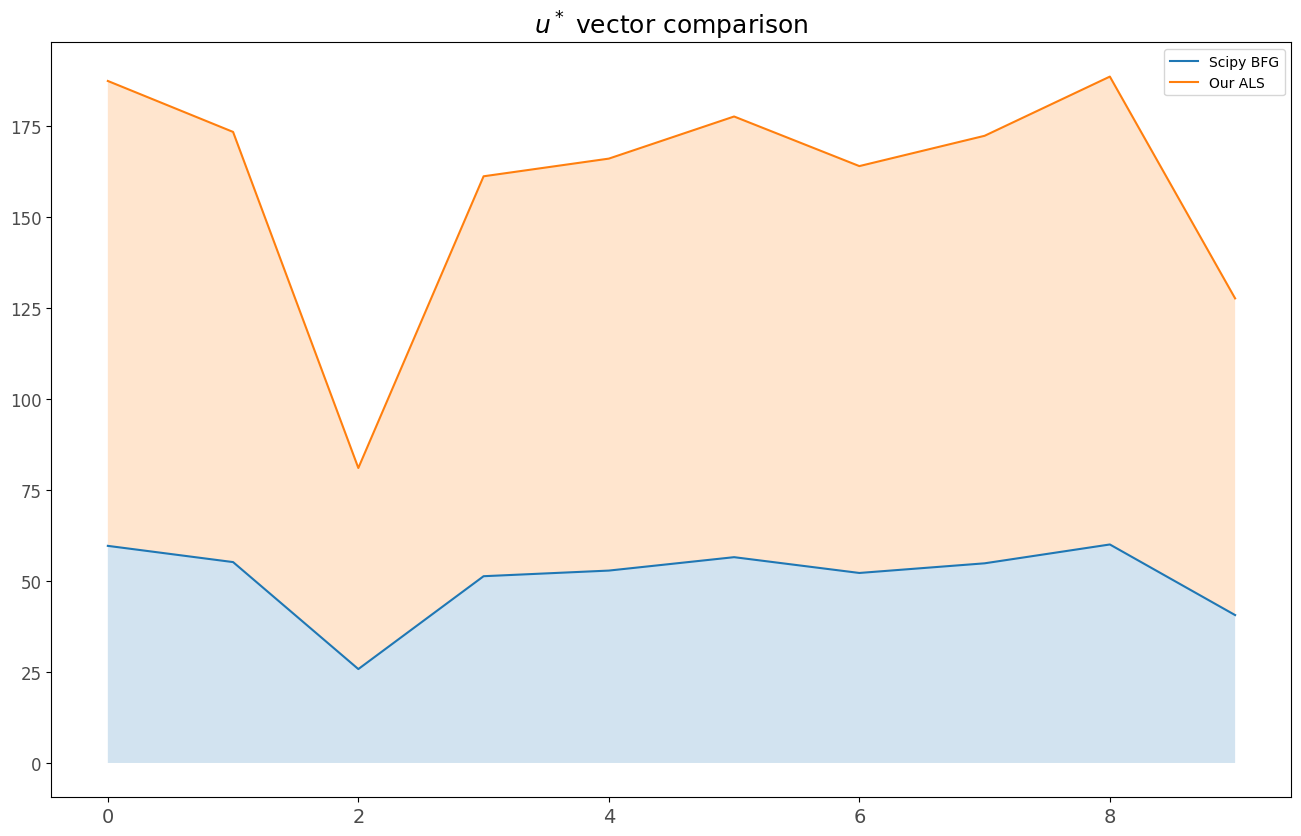

In [55]:
import matplotlib.pyplot as plt 
usol = sol.x[:d.n_users].reshape(-1,)
myu = als.u.reshape(-1,)
plt.figure(figsize=(16,10), dpi=100)
plt.plot(usol, label='Scipy BFG')
plt.fill_between(np.arange(10), usol, np.zeros(10), alpha=0.2)
plt.fill_between(np.arange(10), myu, usol, alpha=0.2)
plt.plot(myu, label='Our ALS')
plt.xticks(fontsize=14, alpha=.7)
# plt.xticks([])
plt.title("$u^*$ vector comparison", fontsize=18)
plt.yticks(fontsize=12, alpha=.7)
# plt.xlim(0,9)
plt.legend()
plt.show()

In [29]:
# normalized diff
ot = our_theta/np.linalg.norm(our_theta)
xyz = sol.x/np.linalg.norm(sol.x)
print("Norm differ", np.linalg.norm(ot-xyz))

Norm differ 41.59103196246087


In [39]:
usol.shape

(10,)